# Project 4: Music Popularity Prediction


# Problem Definition

This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.

The goals for the project are:

- Minimize the cross-validated ***root mean squared error ( RMSE )*** when predicting the popularity of a new song.

- Determine the importance of the features in driving the regression result.
The project will be done using tree-based regression techniques as covered in class. The parameters of the trees should be carefully selected to avoid over-fitting.

There are three main challenges for this project:

1. Determining the outcome ( i.e. target ).  There is a "popularity" column.  But other columns may or may not be more appropriate indicators of popularity.

1. Choosing appropriate predictors ( i.e. features ). When building a machine learning model, we want to make sure that we consider how the model will be ultimately used. For this project, we are predicting the popularity of a new song. Therefore, we should only include the predictors we would have for a new song.

1. Data cleaning and feature engineering. Some creative cleaning and/or feature engineering may be needed to extract useful information for prediction.

# Data Collection/Sources

The data is available AWS at https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv .

The modules used are listed below, but one point of note was how Pandas 2.2.3 read in the dataframe as int/floats whereas on Google Colab running 2.2.2 read them in as objects.

In [1]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
!curl -s -I {url}

HTTP/1.1 200 OK
x-amz-id-2: mXU6+6cNoZTsLolSRF3kZtPR7xDc4zNRqoBCcmM9sWv7s+LXd6pyRRoA2UrkS8/HLQrAY4rvwLU=
x-amz-request-id: 3M58A22PZ9Z4TN9S
Date: Wed, 06 Nov 2024 18:50:07 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Server: AmazonS3
Content-Length: 738124



In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import graphviz
from IPython.display import display
from sklearn.model_selection import GridSearchCV
import pickle
path = '/Users/joeyrobak/Downloads/Spotify.xlsx'

In [3]:
df = pd.read_excel(path)
df

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',48633449,Måneskin,3377762.0,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.800,-4.808,0.0504,0.12700,0.3590,134.002,211560.0,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),47248719,The Kid LAROI,2230022.0,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.03830,0.1030,169.928,141806.0,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,40162559,Olivia Rodrigo,6266514.0,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.1540,0.33500,0.0849,166.928,178147.0,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,37799456,Ed Sheeran,83293380.0,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.04690,0.3640,126.026,231041.0,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),33948454,Lil Nas X,5473565.0,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.02030,0.0501,149.995,212000.0,0.894,D#/Eb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1552,195,1,2019-12-27--2020-01-03,New Rules,4630675,Dua Lipa,27167675.0,2ekn2ttSfGqwhhate0LSR0,"['dance pop', 'pop', 'uk pop']",...,0.762,0.700,-6.021,0.0694,0.00261,0.1530,116.073,209320.0,0.608,A
1552,1553,196,1,2019-12-27--2020-01-03,Cheirosa - Ao Vivo,4623030,Jorge & Mateus,15019109.0,2PWjKmjyTZeDpmOUa3a5da,"['sertanejo', 'sertanejo universitario']",...,0.528,0.870,-3.123,0.0851,0.24000,0.3330,152.370,181930.0,0.714,B
1553,1554,197,1,2019-12-27--2020-01-03,Havana (feat. Young Thug),4620876,Camila Cabello,22698747.0,1rfofaqEpACxVEHIZBJe6W,"['dance pop', 'electropop', 'pop', 'post-teen ...",...,0.765,0.523,-4.333,0.0300,0.18400,0.1320,104.988,217307.0,0.394,D
1554,1555,198,1,2019-12-27--2020-01-03,Surtada - Remix Brega Funk,4607385,"Dadá Boladão, Tati Zaqui, OIK",208630.0,5F8ffc8KWKNawllr5WsW0r,"['brega funk', 'funk carioca']",...,0.832,0.550,-7.026,0.0587,0.24900,0.1820,154.064,152784.0,0.881,F


In [4]:
df.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',48633449,Måneskin,3377762.0,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.800,-4.808,0.0504,0.1270,0.3590,134.002,211560.0,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),47248719,The Kid LAROI,2230022.0,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.1030,169.928,141806.0,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,40162559,Olivia Rodrigo,6266514.0,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.1540,0.3350,0.0849,166.928,178147.0,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,37799456,Ed Sheeran,83293380.0,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.3640,126.026,231041.0,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),33948454,Lil Nas X,5473565.0,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000.0,0.894,D#/Eb


# Data Cleaning

As mentioned above, our data was read in much more efficiently which saved some dataframe cleaning/conversion. Still we need to figure out our target column, and drop columns that are categorical and won't contribute to our model.

In [5]:
df.isna().sum()

Index                         0
Highest Charting Position     0
Number of Times Charted       0
Week of Highest Charting      0
Song Name                     0
Streams                       0
Artist                        0
Artist Followers             11
Song ID                      11
Genre                        11
Release Date                 11
Weeks Charted                 0
Popularity                   11
Danceability                 11
Energy                       11
Loudness                     11
Speechiness                  11
Acousticness                 11
Liveness                     11
Tempo                        11
Duration (ms)                11
Valence                      11
Chord                        11
dtype: int64

In [6]:
df.describe().transpose()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Index                      1556 non-null   int64  
 1   Highest Charting Position  1556 non-null   int64  
 2   Number of Times Charted    1556 non-null   int64  
 3   Week of Highest Charting   1556 non-null   object 
 4   Song Name                  1556 non-null   object 
 5   Streams                    1556 non-null   int64  
 6   Artist                     1556 non-null   object 
 7   Artist Followers           1545 non-null   float64
 8   Song ID                    1545 non-null   object 
 9   Genre                      1545 non-null   object 
 10  Release Date               1545 non-null   object 
 11  Weeks Charted              1556 non-null   object 
 12  Popularity                 1545 non-null   float64
 13  Danceability               1545 non-null   float

In [7]:
df['Genre'].value_counts()

Genre
[]                                                                                              75
['dance pop', 'pop', 'post-teen pop']                                                           71
['latin', 'reggaeton', 'trap latino']                                                           63
['pop', 'post-teen pop']                                                                        57
['melodic rap', 'philly rap', 'rap', 'trap']                                                    33
                                                                                                ..
['tropical house']                                                                               1
['brazilian hip hop', 'funk ostentacao']                                                         1
['australian pop', 'indie cafe pop', 'pop', 'pop rock', 'post-teen pop']                         1
['cubaton', 'dominican pop', 'pop venezolano', 'reggaeton', 'reggaeton flow', 'trap latino']     1
['ga

In [8]:
genre_df=df["Genre"].str.replace(r'[, ]+', ' ', regex=True).str.get_dummies(sep=' ')

In [9]:
genre_df=genre_df[['pop', 'rap', 'country', 'hip']]

In [10]:
chord_df=df['Chord'].str.get_dummies(sep=' ')
chord_df

,A,A#/Bb,B,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab
0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1,0,0,0,0,0,0,0,0,0,0,0
1552,0,0,1,0,0,0,0,0,0,0,0,0
1553,0,0,0,0,0,1,0,0,0,0,0,0
1554,0,0,0,0,0,0,0,0,1,0,0,0


In [11]:
float_df = df.select_dtypes(include='float64')
int_df = df.select_dtypes(include='int64')
num_df = float_df.join(int_df)
num_df=num_df.drop(['Index'], axis =1)
num_df = num_df.join(chord_df)
num_df = num_df.join(genre_df)

In [12]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Artist Followers           1545 non-null   float64
 1   Popularity                 1545 non-null   float64
 2   Danceability               1545 non-null   float64
 3   Energy                     1545 non-null   float64
 4   Loudness                   1545 non-null   float64
 5   Speechiness                1545 non-null   float64
 6   Acousticness               1545 non-null   float64
 7   Liveness                   1545 non-null   float64
 8   Tempo                      1545 non-null   float64
 9   Duration (ms)              1545 non-null   float64
 10  Valence                    1545 non-null   float64
 11  Highest Charting Position  1556 non-null   int64  
 12  Number of Times Charted    1556 non-null   int64  
 13  Streams                    1556 non-null   int64

# Exploratory Data Analysis

In [13]:
target = num_df.pop('Streams')
num_df.insert(0, 'Streams', target)

In [14]:
corr = num_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Highest Charting Position,Number of Times Charted,A,A#/Bb,B,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,pop,rap,country,hip
Streams,1.000000,0.103251,0.123184,-0.081291,0.004145,-0.031155,-0.062620,0.034054,0.042105,0.053458,0.015964,0.038381,-0.295801,-0.061631,0.012575,-0.042221,0.020889,-0.014822,0.011370,0.019130,0.079461,-0.029958,-0.039419,-0.003289,-0.010649,0.023272,-0.023404,-0.008518,0.009239,-0.011118
Artist Followers,0.103251,1.000000,0.104358,-0.097576,-0.065613,-0.033264,-0.072968,0.023830,-0.012491,-0.019881,0.142145,-0.108804,-0.233723,0.027458,0.030509,0.000863,-0.052215,0.058909,-0.015644,-0.005232,-0.011527,0.018885,0.025804,-0.034006,0.007583,-0.026775,-0.036641,-0.019167,-0.030052,-0.084205
Popularity,0.123184,0.104358,1.000000,0.028435,0.094691,0.158767,-0.032091,-0.091245,-0.029460,-0.024951,0.082096,-0.000953,-0.164167,0.232796,0.017941,-0.050052,-0.025659,-0.022178,-0.026783,-0.002726,0.056792,0.023826,0.019726,0.040082,0.019185,-0.014829,0.006154,0.003074,-0.014997,-0.017851
Danceability,-0.081291,-0.097576,0.028435,1.000000,0.142130,0.234928,0.237394,-0.316798,-0.114518,-0.040219,-0.101390,0.361627,0.017149,0.027026,-0.024569,0.025844,0.097202,-0.044942,-0.001228,-0.058850,-0.023237,-0.046709,-0.010811,0.019987,-0.009201,0.063357,0.006084,0.016800,-0.018709,0.209109
Energy,0.004145,-0.065613,0.094691,0.142130,1.000000,0.732616,0.023989,-0.542399,0.124693,0.113352,0.056624,0.356325,0.063026,-0.061139,-0.007852,0.058894,0.026301,-0.074609,-0.006078,0.011302,-0.014731,-0.047480,0.017781,0.049235,0.010616,-0.023332,0.019242,-0.016464,0.007245,0.029715
Loudness,-0.031155,-0.033264,0.158767,0.234928,0.732616,1.000000,-0.018823,-0.477431,0.043141,0.104371,0.075262,0.298762,0.032166,0.031225,0.004909,0.017559,-0.000615,-0.056499,0.024479,-0.010077,0.021580,-0.053729,0.008524,0.061455,-0.005132,-0.005485,0.030191,-0.013519,0.010290,0.022172
Speechiness,-0.062620,-0.072968,-0.032091,0.237394,0.023989,-0.018823,1.000000,-0.131436,0.072774,0.111255,-0.089895,0.038032,0.041248,-0.060216,-0.008191,0.043950,0.035909,-0.087669,0.074770,0.030730,-0.029424,-0.030150,-0.041344,-0.007786,-0.018638,0.012580,-0.005555,-0.011406,-0.025010,0.294307
Acousticness,0.034054,0.023830,-0.091245,-0.316798,-0.542399,-0.477431,-0.131436,1.000000,-0.005469,-0.061632,-0.046010,-0.096997,-0.012924,0.046651,0.027570,-0.027616,-0.028475,0.073474,-0.036888,0.016035,0.025396,0.053443,-0.029145,-0.024056,-0.037220,0.006694,-0.020888,0.044168,0.025509,-0.140473
Liveness,0.042105,-0.012491,-0.029460,-0.114518,0.124693,0.043141,0.072774,-0.005469,1.000000,-0.018265,0.019685,0.007882,0.012718,-0.058436,0.010247,0.000635,-0.029220,-0.014177,-0.011101,0.018944,-0.002134,0.005401,0.032542,-0.041653,0.039818,-0.006367,-0.008110,-0.011168,0.027572,0.056196
Tempo,0.053458,-0.019881,-0.024951,-0.040219,0.113352,0.104371,0.111255,-0.061632,-0.018265,1.000000,-0.004671,0.057563,0.026235,-0.048307,0.005432,0.006528,-0.011825,0.014998,0.037612,0.007148,-0.042885,-0.043933,-0.009969,0.011605,-0.005523,0.000650,-0.027348,0.009661,-0.031404,0.007664


In [15]:
num_df=num_df.dropna()

In [17]:
num_df

,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,...,D#/Eb,E,F,F#/Gb,G,G#/Ab,pop,rap,country,hip
0,48633449,3377762.0,100.0,0.714,0.800,-4.808,0.0504,0.12700,0.3590,134.002,...,0,0,0,0,0,0,0,0,0,0
1,47248719,2230022.0,99.0,0.591,0.764,-5.484,0.0483,0.03830,0.1030,169.928,...,0,0,0,0,0,0,0,0,0,1
2,40162559,6266514.0,99.0,0.563,0.664,-5.044,0.1540,0.33500,0.0849,166.928,...,0,0,0,0,0,0,0,0,0,0
3,37799456,83293380.0,98.0,0.808,0.897,-3.712,0.0348,0.04690,0.3640,126.026,...,0,0,0,0,0,0,0,0,0,0
4,33948454,5473565.0,96.0,0.736,0.704,-7.409,0.0615,0.02030,0.0501,149.995,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,4630675,27167675.0,79.0,0.762,0.700,-6.021,0.0694,0.00261,0.1530,116.073,...,0,0,0,0,0,0,0,0,0,0
1552,4623030,15019109.0,66.0,0.528,0.870,-3.123,0.0851,0.24000,0.3330,152.370,...,0,0,0,0,0,0,0,0,0,0
1553,4620876,22698747.0,81.0,0.765,0.523,-4.333,0.0300,0.18400,0.1320,104.988,...,0,0,0,0,0,0,0,0,0,0
1554,4607385,208630.0,60.0,0.832,0.550,-7.026,0.0587,0.24900,0.1820,154.064,...,0,0,1,0,0,0,0,0,0,0


# Processing

In [18]:
numLoops = 500

mean_error = np.zeros(numLoops)

# np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=5, random_state=0)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  mean_error[idx] = mean_squared_error(y_test, y_pred)

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')

RMSE: 522131.8162486936
RMSE_std: 77145.64173487463


In [19]:
max_depths = [1,2,3,4,5,6,7,8,9,10]
rms_depth = np.zeros(len(max_depths))
std_depth = np.zeros(len(max_depths))

numLoops = 500

for n, depth in enumerate(max_depths):
  rms_error = np.zeros(numLoops)

  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

  rms_depth[n] = rms_error.mean()
  std_depth[n] = rms_error.std( ddof = 1 )


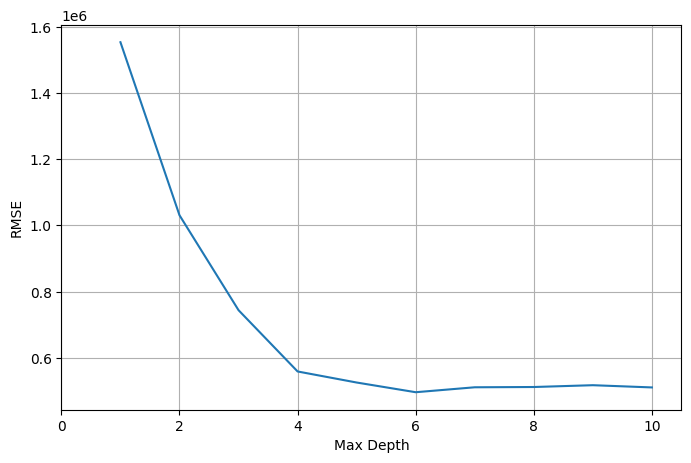

In [20]:
# Plot result
plt.figure(figsize = (8,5))
plt.plot(max_depths, rms_depth)
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.xlim(0, 10.5)
plt.grid()

In [21]:
numLoops = 500

mean_error = np.zeros(numLoops)

# np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )
  model = RandomForestRegressor( n_estimators = 10 ) #n_estimators is number of trees in forest. Note: you can also choose max_depth for RFs
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  mean_error[idx] = mean_squared_error( y_test, y_pred )

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')

RMSE: 427045.1784653354
RMSE_std: 75912.79267082659


In [22]:
num_trees = range(10,60,10)
cv_loops = 100
rmse_results = np.zeros(len(num_trees))
std_results = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees):
  rmse_cv = np.zeros(cv_loops)
  np.random.seed(42)
  for i in range(cv_loops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
    rfModel = RandomForestRegressor( n_estimators=trees )
    rfModel.fit(X_train, y_train)
    y_pred_rf = rfModel.predict(X_test)
    rmse_cv[i] = np.sqrt(mean_squared_error(y_test, y_pred_rf))

  print(trees,' trees finished.')
  rmse_results[n] = rmse_cv.mean()
  std_results[n] = rmse_cv.std()


10  trees finished.
20  trees finished.
30  trees finished.
40  trees finished.
50  trees finished.


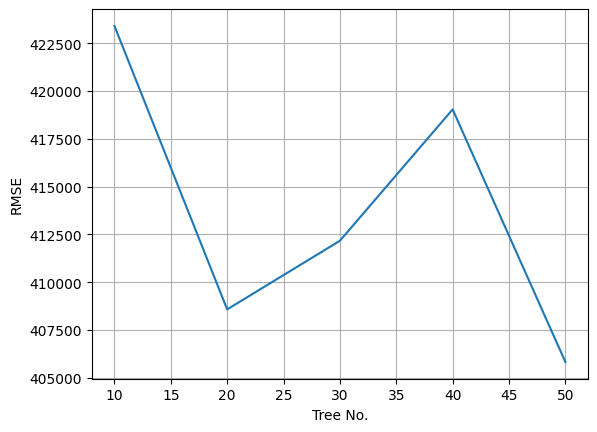

In [23]:
plt.plot(num_trees, rmse_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.grid()

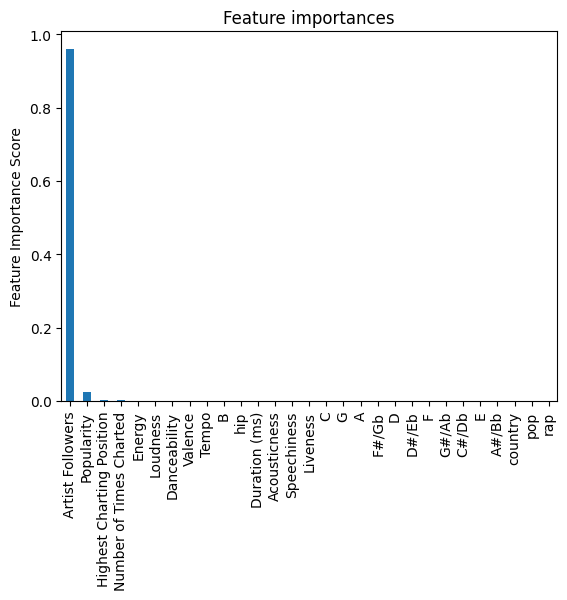

In [24]:
importances = rfModel.feature_importances_
forest_importances = pd.Series( importances, index = X.columns )

plt.figure()
# forest_importances.plot.bar()
forest_importances.sort_values( ascending = False ).plot.bar()
plt.title("Feature importances")
plt.ylabel('Feature Importance Score') ;

In [25]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.15 )
  xgbr = xgb.XGBRegressor(
      objective ='reg:squarederror',
      verbosity=0,
      learning_rate = 0.2,
      max_depth = 3,
      n_estimators = 100,
      seed = 10,
  )
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

RMSE: 276784.7616875117


/var/folders/nl/cvxy58ks2mg_jyg002l659xc0000gn/T/ipykernel_61517/1773137962.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )


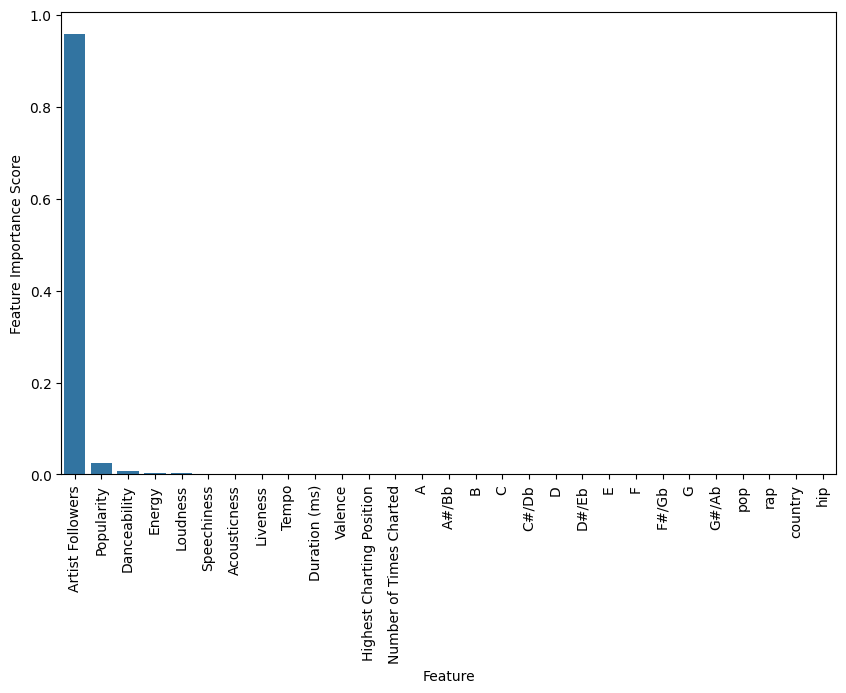

In [26]:
feat_imp = pd.Series(xgbr.feature_importances_, index=X.columns)
plt.figure(figsize = (10,6))
# ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
ax = sns.barplot(x = feat_imp.index, y = feat_imp.sort_values( ascending = False ).values )
ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score') ;

# Data Visualization/Communication of Results

Our model predicted artist followers as the most significant contributor to having an accurate model. Using the "get dummies" method for the chord data and also encoding for 4 different genres increased our model accuracy. With each different model used, the RMSE was significantly lowered. Overall I think this project went smoother than previous ones, and found more need to use a smaller sample-size before running the entire dataframe increased productivity and will cost much less when working in the professional world.